<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 12:44:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 7.9MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 174kB 34.7MB/s 
     |████████████████████████████████| 143kB 40.6MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: xd2amyxo
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/xd2amyxo


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: gtw6f3gc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 31s 173ms/step - loss: 0.1036 - mean_squared_error: 0.1036 - mean_absolute_error: 0.2460 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.2056
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0923 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1569
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0643 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1517
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0560 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1493
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0053 - mean_squared_err

epoch,49
loss,0.003
mean_squared_error,0.003
mean_absolute_error,0.04241
val_loss,0.02258
val_mean_squared_error,0.02258
val_mean_absolute_error,0.11877
_runtime,58
_timestamp,1626266829
_step,49
best_val_loss,0.02127


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gfp0zjt5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 11s 344ms/step - loss: 0.1360 - mean_squared_error: 0.1360 - mean_absolute_error: 0.3021 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1706
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1536 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1476
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1121 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1440
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0902 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1447
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0108 - mean_squared_error: 0

epoch,99
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03556
val_loss,0.01058
val_mean_squared_error,0.01058
val_mean_absolute_error,0.08022
_runtime,37
_timestamp,1626266873
_step,99
best_val_loss,0.01038


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▄▄▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c9uuxepj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 163ms/step - loss: 0.1112 - mean_squared_error: 0.1112 - mean_absolute_error: 0.2541 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1552
Epoch 2/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0933 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1610
Epoch 3/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0923 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1515
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0881 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1744
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0105 - mean_square

epoch,199
loss,0.00244
mean_squared_error,0.00244
mean_absolute_error,0.03745
val_loss,0.01471
val_mean_squared_error,0.01471
val_mean_absolute_error,0.09593
_runtime,85
_timestamp,1626266966
_step,199
best_val_loss,0.0117


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▆▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▆▆▆▅▅▄▄▄▄▄▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂
val_mean_squared_error,▇█▆▆▆▆▅▅▄▄▄▄▄▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂
val_mean_absolute_error,█▇▆▆▆▇▅▅▅▅▅▄▄▄▄▄▅▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cbh09nuw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 11s 174ms/step - loss: 0.3641 - mean_squared_error: 0.3641 - mean_absolute_error: 0.3635 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1706
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0768 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1743
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0845 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1947
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0997 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1640
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0214 - mean_squared_err

epoch,49
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.04548
val_loss,0.01389
val_mean_squared_error,0.01389
val_mean_absolute_error,0.0947
_runtime,37
_timestamp,1626267028
_step,49
best_val_loss,0.01301


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▅█▄▇▄▅▇▃▃▃▃▃▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,▆▆█▅█▄▇▄▅▇▃▃▃▃▃▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,▆▆█▆█▄▇▄▅▇▃▄▃▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7no9atsa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 11s 162ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - mean_absolute_error: 0.2404 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1733
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0983 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1700
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0888 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1661
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0907 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1678
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0115 - mean_square

epoch,99
loss,0.00385
mean_squared_error,0.00385
mean_absolute_error,0.04699
val_loss,0.01939
val_mean_squared_error,0.01939
val_mean_absolute_error,0.10952
_runtime,52
_timestamp,1626267088
_step,99
best_val_loss,0.01939


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▇▇▆▅▆▄▄▄▅▄▃▃▃▃▃▃▄▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁
val_mean_squared_error,██▇▆▆▇▇▆▅▆▄▄▄▅▄▃▃▃▃▃▃▄▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁
val_mean_absolute_error,█▇▆▆▆▇▇▅▄▄▄▄▃▅▃▃▃▃▃▃▃▄▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eko5ye3j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 12s 89ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - mean_absolute_error: 0.1680 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1672
Epoch 2/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0847 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1842
Epoch 3/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0820 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1453
Epoch 4/200
32/32 [==============================] - 1s 18ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0800 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1781
Epoch 5/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0080 - mean_squared

epoch,154
loss,0.00161
mean_squared_error,0.00161
mean_absolute_error,0.02998
val_loss,0.00723
val_mean_squared_error,0.00723
val_mean_absolute_error,0.0659
_runtime,116
_timestamp,1626267212
_step,154
best_val_loss,0.00679


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kcwsoli8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 11s 167ms/step - loss: 0.1693 - mean_squared_error: 0.1693 - mean_absolute_error: 0.3447 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1771
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1346 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1774
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1102 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1699
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0994 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1581
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0150 - mean_square

epoch,70
loss,0.00482
mean_squared_error,0.00482
mean_absolute_error,0.05228
val_loss,0.02468
val_mean_squared_error,0.02468
val_mean_absolute_error,0.12537
_runtime,44
_timestamp,1626267303
_step,70
best_val_loss,0.02425


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▅▆▅▅▆▄▄▄▃▄▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,██▇▆▆▅▅▆▅▅▆▄▄▄▃▄▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,██▅▅▆▄▄▅▄▄▅▄▃▃▃▄▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s32k9pcw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 328ms/step - loss: 0.1452 - mean_squared_error: 0.1452 - mean_absolute_error: 0.3019 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1660
Epoch 2/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1346 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_mean_absolute_error: 0.2106
Epoch 3/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1032 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1482
Epoch 4/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0758 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1684
Epoch 5/200
8/8 [==============================] - 0s 26ms/step - loss: 0.0064 - mean_squared_error: 0

epoch,199
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.03087
val_loss,0.01037
val_mean_squared_error,0.01037
val_mean_absolute_error,0.08018
_runtime,64
_timestamp,1626267376
_step,199
best_val_loss,0.00953


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b2xtdb19 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 178ms/step - loss: 2.4800 - mean_squared_error: 2.4800 - mean_absolute_error: 0.7664 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - val_mean_absolute_error: 0.2143
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0941 - val_loss: 0.0711 - val_mean_squared_error: 0.0711 - val_mean_absolute_error: 0.2111
Epoch 3/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1294 - val_loss: 0.0587 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.1982
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1431 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.1890
Epoch 5/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0265 - mean_square

epoch,53
loss,0.0031
mean_squared_error,0.0031
mean_absolute_error,0.04312
val_loss,0.01052
val_mean_squared_error,0.01052
val_mean_absolute_error,0.07852
_runtime,37
_timestamp,1626267422
_step,53
best_val_loss,0.00751


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▄▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▅▄▄█▃▂▄▃▅▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▅▅▄▄█▃▂▄▃▅▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▆▅▅▅█▄▃▅▄▆▄▄▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p3rjpv5k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 11s 105ms/step - loss: 0.1110 - mean_squared_error: 0.1110 - mean_absolute_error: 0.2510 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1701
Epoch 2/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0787 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1603
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0788 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1982
Epoch 4/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0791 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1958
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0087 - mean_squared_err

epoch,49
loss,0.00367
mean_squared_error,0.00367
mean_absolute_error,0.04538
val_loss,0.02116
val_mean_squared_error,0.02116
val_mean_absolute_error,0.11446
_runtime,50
_timestamp,1626267499
_step,49
best_val_loss,0.02116


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅██▅▆▄▄▄▄▄▄▃▃▃▄▂▃▃▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▆▅██▅▆▄▄▄▄▄▄▃▃▃▄▂▃▃▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▆▅██▅▆▄▄▃▄▅▃▃▃▄▄▂▄▃▃▂▂▃▂▂▁▂▃▂▂▁▂▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o4rx6o3p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 335ms/step - loss: 0.2140 - mean_squared_error: 0.2140 - mean_absolute_error: 0.4093 - val_loss: 0.0788 - val_mean_squared_error: 0.0788 - val_mean_absolute_error: 0.2158
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1679 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1785
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0961 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1753
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0876 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1670
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0095 - mean_squared_error: 0

epoch,99
loss,0.00509
mean_squared_error,0.00509
mean_absolute_error,0.05574
val_loss,0.02903
val_mean_squared_error,0.02903
val_mean_absolute_error,0.13793
_runtime,45
_timestamp,1626267553
_step,99
best_val_loss,0.02656


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▄▃▃▃▃▂▄▃▃▃▃▄▂▂▂▃▃▂▃▂▁▂▂▂▂▂▁▁▁▂▂▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pqu6tu7f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 11s 338ms/step - loss: 0.1539 - mean_squared_error: 0.1539 - mean_absolute_error: 0.3134 - val_loss: 0.0501 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1949
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1258 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1569
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1136 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1869
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1166 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1592
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0188 - mean_squared_error: 0

epoch,99
loss,0.00508
mean_squared_error,0.00508
mean_absolute_error,0.05352
val_loss,0.02214
val_mean_squared_error,0.02214
val_mean_absolute_error,0.11722
_runtime,39
_timestamp,1626267613
_step,99
best_val_loss,0.02096


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆█▇▅▄▄▄▄▃▃▃▃▄▃▂▂▂▂▂▂▂▃▂▁▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁
val_mean_squared_error,▇▆█▇▅▄▄▄▄▃▃▃▃▄▃▂▂▂▂▂▂▂▃▂▁▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁
val_mean_absolute_error,▇▇█▇▅▄▄▃▄▃▃▃▄▃▃▂▂▂▃▃▂▂▃▂▂▁▂▂▂▂▁▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qo48zkvj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 345ms/step - loss: 0.1303 - mean_squared_error: 0.1303 - mean_absolute_error: 0.2813 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1562
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1144 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - val_mean_absolute_error: 0.2885
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1969 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1823
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1166 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1727
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0164 - mean_squared_error: 0

epoch,99
loss,0.00231
mean_squared_error,0.00231
mean_absolute_error,0.03607
val_loss,0.01236
val_mean_squared_error,0.01236
val_mean_absolute_error,0.08735
_runtime,46
_timestamp,1626267670
_step,99
best_val_loss,0.01226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▇▆▅▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁
val_mean_squared_error,▆█▆▇▆▅▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁
val_mean_absolute_error,▆█▆▆▆▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aqfv8gz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 11s 330ms/step - loss: 1.2558 - mean_squared_error: 1.2558 - mean_absolute_error: 0.6719 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1685
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.2161 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1839
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1681 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1655
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1297 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1543
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0084 - mean_squared_error: 0

epoch,99
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02794
val_loss,0.00981
val_mean_squared_error,0.00981
val_mean_absolute_error,0.07742
_runtime,43
_timestamp,1626267723
_step,99
best_val_loss,0.00981


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▅▅▅▅▅▄▄▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 512unxcl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 11s 90ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.1940 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1576
Epoch 2/200
32/32 [==============================] - 1s 21ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0838 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1758
Epoch 3/200
32/32 [==============================] - 1s 21ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0751 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1618
Epoch 4/200
32/32 [==============================] - 1s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0693 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1463
Epoch 5/200
32/32 [==============================] - 1s 21ms/step - loss: 0.0093 - mean_squared

epoch,199
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02482
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05816
_runtime,157
_timestamp,1626267902
_step,199
best_val_loss,0.0056


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▅▅▅▄▄▄▄▃▃▄▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kaycpp8n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 410ms/step - loss: 0.1446 - mean_squared_error: 0.1446 - mean_absolute_error: 0.3142 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1803
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0706 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1673
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0644 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1649
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0614 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1565
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0115 - mean_squared_error: 0

epoch,99
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.03973
val_loss,0.02301
val_mean_squared_error,0.02301
val_mean_absolute_error,0.12112
_runtime,46
_timestamp,1626267959
_step,99
best_val_loss,0.02219


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▆▆▆▆▅▇▄▅▄▄▄▃▃▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁
val_mean_squared_error,█▇█▆▆▆▆▅▇▄▅▄▄▄▃▃▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁
val_mean_absolute_error,█▆█▅▅▅▅▅▇▄▅▄▄▃▃▃▄▄▃▃▃▃▃▃▃▃▂▂▁▂▂▂▂▂▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c0j1nmq9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 11s 89ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - mean_absolute_error: 0.2424 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1813
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0795 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1533
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0616 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1638
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0619 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1557
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0062 - mean_squared

epoch,99
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.03365
val_loss,0.01558
val_mean_squared_error,0.01558
val_mean_absolute_error,0.09867
_runtime,91
_timestamp,1626268072
_step,99
best_val_loss,0.01558


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9qjiuqw8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 12s 416ms/step - loss: 0.1663 - mean_squared_error: 0.1663 - mean_absolute_error: 0.3424 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1661
Epoch 2/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0785 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1725
Epoch 3/200
8/8 [==============================] - 0s 29ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0709 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1680
Epoch 4/200
8/8 [==============================] - 0s 28ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0635 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1757
Epoch 5/200
8/8 [==============================] - 0s 33ms/step - loss: 0.0069 - mean_squared_error: 0

epoch,199
loss,0.00233
mean_squared_error,0.00233
mean_absolute_error,0.03698
val_loss,0.01861
val_mean_squared_error,0.01861
val_mean_absolute_error,0.10746
_runtime,75
_timestamp,1626268158
_step,199
best_val_loss,0.01714


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▄▄▄▃▄▃▄▃▃▃▄▂▂▃▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,██▅▄▄▄▃▄▃▄▃▃▃▄▂▂▃▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▆▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁
val_loss,█▇▇▆▅▆▅▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▆▅▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▇▆▅▆▅▆▅▅▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mh17h1qp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 11s 333ms/step - loss: 0.1827 - mean_squared_error: 0.1827 - mean_absolute_error: 0.3671 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1619
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1569 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1663
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1183 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1553
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1161 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1787
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0198 - mean_squared_error: 0

epoch,14
loss,0.01005
mean_squared_error,0.01005
mean_absolute_error,0.07794
val_loss,0.03745
val_mean_squared_error,0.03745
val_mean_absolute_error,0.15355
_runtime,21
_timestamp,1626268214
_step,14
best_val_loss,0.03607


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▄█▁▃▄▅▄▄▃▄▃▃▂
val_mean_squared_error,▃▄▄█▁▃▄▅▄▄▃▄▃▃▂
val_mean_absolute_error,▃▅▂█▁▃▂▂▂▂▁▃▁▂▁
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆███
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆███
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: s1zesgw2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 11s 416ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - mean_absolute_error: 0.3351 - val_loss: 0.0820 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2526
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1448 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1577
Epoch 3/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1096 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1905
Epoch 4/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1000 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1518
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0110 - mean_squared_error: 0.0110

epoch,49
loss,0.00491
mean_squared_error,0.00491
mean_absolute_error,0.05435
val_loss,0.02659
val_mean_squared_error,0.02659
val_mean_absolute_error,0.12944
_runtime,30
_timestamp,1626268257
_step,49
best_val_loss,0.02659


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▃▂▃▂▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ypups0wq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 11s 104ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - mean_absolute_error: 0.2057 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1689
Epoch 2/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0662 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1500
Epoch 3/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0614 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1461
Epoch 4/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0601 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1457
Epoch 5/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0052 - mean_square

epoch,144
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02466
val_loss,0.00612
val_mean_squared_error,0.00612
val_mean_absolute_error,0.06014
_runtime,128
_timestamp,1626268397
_step,144
best_val_loss,0.00597


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▅▅▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▇▅▅▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▇▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▅▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ft2mkwxj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 11s 207ms/step - loss: 0.1034 - mean_squared_error: 0.1034 - mean_absolute_error: 0.2587 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1545
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1046 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1645
Epoch 3/100
16/16 [==============================] - 0s 29ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0775 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1646
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0728 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1560
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0087 - mean_square

epoch,66
loss,0.00336
mean_squared_error,0.00336
mean_absolute_error,0.04439
val_loss,0.02485
val_mean_squared_error,0.02485
val_mean_absolute_error,0.12553
_runtime,46
_timestamp,1626268480
_step,66
best_val_loss,0.02386


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▇▅▅▅▅▅▆▄▅▃▄▃▃▂▂▂▂▂▁▁▂▂▂▂▁▁▂▁▂▁▂▁▁
val_mean_squared_error,█████▇▇▇▅▅▅▅▅▆▄▅▃▄▃▃▂▂▂▂▂▁▁▂▂▂▂▁▁▂▁▂▁▂▁▁
val_mean_absolute_error,▆█▇▇▇▆▆▆▅▅▅▅▅▆▃▄▂▃▃▂▂▂▂▂▁▁▂▂▂▂▂▁▂▂▁▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e40oboso with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 11s 170ms/step - loss: 0.1719 - mean_squared_error: 0.1719 - mean_absolute_error: 0.3239 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1675
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1585 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1426
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1030 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1640
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1226 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1379
Epoch 5/100
16/16 [==============================] - 0s 24ms/step - loss: 0.0155 - mean_square

epoch,64
loss,0.00284
mean_squared_error,0.00284
mean_absolute_error,0.0409
val_loss,0.01123
val_mean_squared_error,0.01123
val_mean_absolute_error,0.08792
_runtime,45
_timestamp,1626268544
_step,64
best_val_loss,0.00611


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▇▅▅▇▇▄▄▃▃▃▅▃▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▂
val_mean_squared_error,█▇▆▇▅▅▇▇▄▄▃▃▃▅▃▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▂
val_mean_absolute_error,█▆▆▇▅▅▇▆▄▄▄▄▄▅▄▃▃▃▂▃▂▂▂▃▃▂▂▁▂▁▃▁▂▁▁▃▂▁▁▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ddgqd11x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 10s 328ms/step - loss: 0.6041 - mean_squared_error: 0.6041 - mean_absolute_error: 0.5494 - val_loss: 0.0684 - val_mean_squared_error: 0.0684 - val_mean_absolute_error: 0.2111
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1087 - val_loss: 0.0871 - val_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.2423
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1676 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.1947
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1544 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2020
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0309 - mean_squared_error: 0

epoch,81
loss,0.00393
mean_squared_error,0.00393
mean_absolute_error,0.04894
val_loss,0.01485
val_mean_squared_error,0.01485
val_mean_absolute_error,0.09789
_runtime,38
_timestamp,1626268602
_step,81
best_val_loss,0.00881


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▃▂▃▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▄▃▅▄█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▄▃▅▄█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▅▄▆▅█▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p4d6j1oy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 10s 319ms/step - loss: 0.1863 - mean_squared_error: 0.1863 - mean_absolute_error: 0.3629 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - val_mean_absolute_error: 0.2543
Epoch 2/200
8/8 [==============================] - 0s 28ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1795 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1603
Epoch 3/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1343 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1766
Epoch 4/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1163 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1506
Epoch 5/200
8/8 [==============================] - 0s 26ms/step - loss: 0.0176 - mean_squared_error: 0

epoch,71
loss,0.00519
mean_squared_error,0.00519
mean_absolute_error,0.05485
val_loss,0.02581
val_mean_squared_error,0.02581
val_mean_absolute_error,0.12929
_runtime,38
_timestamp,1626268667
_step,71
best_val_loss,0.02512


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pawou9qb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 11s 90ms/step - loss: 0.2572 - mean_squared_error: 0.2572 - mean_absolute_error: 0.3554 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1854
Epoch 2/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1414 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1767
Epoch 3/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1154 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1469
Epoch 4/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1051 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1290
Epoch 5/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0119 - mean_squared_erro

epoch,38
loss,0.00308
mean_squared_error,0.00308
mean_absolute_error,0.04135
val_loss,0.00959
val_mean_squared_error,0.00959
val_mean_absolute_error,0.07997
_runtime,46
_timestamp,1626268727
_step,38
best_val_loss,0.00629


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▄▄▅▃▄▅▂▂▂▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂
val_mean_squared_error,██▅▄▄▅▃▄▅▂▂▂▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂
val_mean_absolute_error,██▆▅▅▆▄▅▅▃▂▃▄▂▃▃▂▂▂▃▂▂▁▁▂▁▁▂▁▁▂▂▁▁▃▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pf3c46xw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 12s 94ms/step - loss: 0.0813 - mean_squared_error: 0.0813 - mean_absolute_error: 0.1937 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1569
Epoch 2/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0773 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1664
Epoch 3/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0714 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1505
Epoch 4/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0656 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1623
Epoch 5/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0069 - mean_squared_erro

epoch,49
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03511
val_loss,0.01638
val_mean_squared_error,0.01638
val_mean_absolute_error,0.10077
_runtime,66
_timestamp,1626268807
_step,49
best_val_loss,0.01638


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆█▅▇▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆█▅▇▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁
val_mean_absolute_error,▇█▆█▅▅█▅▇▆▄▄▄▄▄▅▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 85m8kcnj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 10s 162ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - mean_absolute_error: 0.2134 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1597
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0968 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1538
Epoch 3/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0806 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1620
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0856 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1518
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0117 - mean_square

epoch,99
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.04083
val_loss,0.0138
val_mean_squared_error,0.0138
val_mean_absolute_error,0.0934
_runtime,59
_timestamp,1626268880
_step,99
best_val_loss,0.0138


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▆▅▅▄▄▄▅▃▃▆▃▃▃▃▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
val_mean_squared_error,█▇▆▆▆▆▅▅▄▄▄▅▃▃▆▃▃▃▃▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
val_mean_absolute_error,██▆▇▆▇▆▆▅▅▄▆▄▄▇▄▄▄▄▃▄▄▄▅▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4fgjxhva with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 12s 86ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - mean_absolute_error: 0.1854 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1511
Epoch 2/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0919 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1631
Epoch 3/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0891 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1770
Epoch 4/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0843 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1381
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0091 - mean_squared_erro

epoch,49
loss,0.00256
mean_squared_error,0.00256
mean_absolute_error,0.03776
val_loss,0.01016
val_mean_squared_error,0.01016
val_mean_absolute_error,0.07958
_runtime,58
_timestamp,1626268990
_step,49
best_val_loss,0.01016


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁
val_mean_squared_error,▇▇█▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁
val_mean_absolute_error,▆▇█▅▅▅▅▆▄▅▅▄▄▅▄▄▃▃▃▃▃▄▃▃▃▂▃▃▂▂▂▂▁▁▂▂▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bmjj0t7t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 12s 176ms/step - loss: 0.2303 - mean_squared_error: 0.2303 - mean_absolute_error: 0.3474 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1737
Epoch 2/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1421 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1932
Epoch 3/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0848 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1381
Epoch 4/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0708 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1455
Epoch 5/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0075 - mean_square

epoch,199
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.0279
val_loss,0.006
val_mean_squared_error,0.006
val_mean_absolute_error,0.06026
_runtime,111
_timestamp,1626269115
_step,199
best_val_loss,0.00578


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7fmgn6gy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 169ms/step - loss: 0.1178 - mean_squared_error: 0.1178 - mean_absolute_error: 0.2534 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1404
Epoch 2/200
16/16 [==============================] - 0s 27ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0909 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1457
Epoch 3/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0770 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1389
Epoch 4/200
16/16 [==============================] - 0s 28ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0713 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1401
Epoch 5/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0092 - mean_square

epoch,140
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02974
val_loss,0.00696
val_mean_squared_error,0.00696
val_mean_absolute_error,0.0624
_runtime,83
_timestamp,1626269212
_step,140
best_val_loss,0.00624


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▆▇▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▆▇▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▆▇▆▅▅▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4ew3wdq3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 12s 90ms/step - loss: 0.1454 - mean_squared_error: 0.1454 - mean_absolute_error: 0.3177 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1644
Epoch 2/200
32/32 [==============================] - 1s 22ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1356 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1505
Epoch 3/200
32/32 [==============================] - 1s 24ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1384 - val_loss: 0.0662 - val_mean_squared_error: 0.0662 - val_mean_absolute_error: 0.2062
Epoch 4/200
32/32 [==============================] - 1s 22ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0963 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1462
Epoch 5/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0183 - mean_squared

epoch,46
loss,0.00317
mean_squared_error,0.00317
mean_absolute_error,0.04332
val_loss,0.00775
val_mean_squared_error,0.00775
val_mean_absolute_error,0.06693
_runtime,55
_timestamp,1626269284
_step,46
best_val_loss,0.00652


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▄▃▅▃▃▃▂▂▄▁▂▂▂▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▅▄█▄▃▅▃▃▃▂▂▄▁▂▂▂▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▆▅█▅▄▆▄▄▄▃▃▅▂▃▃▃▂▂▂▂▂▁▂▂▁▁▂▃▂▁▂▁▁▁▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z1a34cw0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 11s 352ms/step - loss: 0.3818 - mean_squared_error: 0.3818 - mean_absolute_error: 0.4560 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1566
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1241 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1607
Epoch 3/50
8/8 [==============================] - 0s 32ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1017 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1840
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1090 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1929
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0248 - mean_squared_error: 0.0248

epoch,49
loss,0.00438
mean_squared_error,0.00438
mean_absolute_error,0.04988
val_loss,0.01091
val_mean_squared_error,0.01091
val_mean_absolute_error,0.08092
_runtime,33
_timestamp,1626269332
_step,49
best_val_loss,0.01091


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▇██▆▆▅▅▆▄▆▆▇▄▄▄▃▃▄▃▃▃▃▃▂▂▂▄▂▂▂▃▃▂▂▁▂▂▁
val_mean_squared_error,▆▆▇██▆▆▅▅▆▄▆▆▇▄▄▄▃▃▄▃▃▃▃▃▂▂▂▄▂▂▂▃▃▂▂▁▂▂▁
val_mean_absolute_error,▆▆▇██▆▆▆▆▇▄▆▆▆▄▄▄▄▃▄▃▃▃▃▃▃▂▂▅▂▂▃▃▃▂▂▁▂▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: y7ieap8y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 11s 169ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - mean_absolute_error: 0.2714 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1842
Epoch 2/100
16/16 [==============================] - 0s 28ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1205 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1568
Epoch 3/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0732 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1493
Epoch 4/100
16/16 [==============================] - 0s 26ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0672 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1474
Epoch 5/100
16/16 [==============================] - 0s 24ms/step - loss: 0.0079 - mean_square

epoch,99
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.03278
val_loss,0.00864
val_mean_squared_error,0.00864
val_mean_absolute_error,0.07352
_runtime,67
_timestamp,1626269418
_step,99
best_val_loss,0.0083


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lt8i4yvc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'dropout': 0.2,
    'input_size': 50,
    'hidden_size': 50,
    'learning_rate': 0.0005,
    'optimizer': 'rmsprop',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  71051


In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 8s 13ms/step - loss: 0.0570
Epoch 2/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0078
Epoch 3/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0076
Epoch 4/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0066
Epoch 5/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0087
Epoch 6/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 7/200
40/40 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 8/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0055
Epoch 9/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 10/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0052
Epoch 11/200
40/40 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 12/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0049
Epoch 13/200
40/40 [=====

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

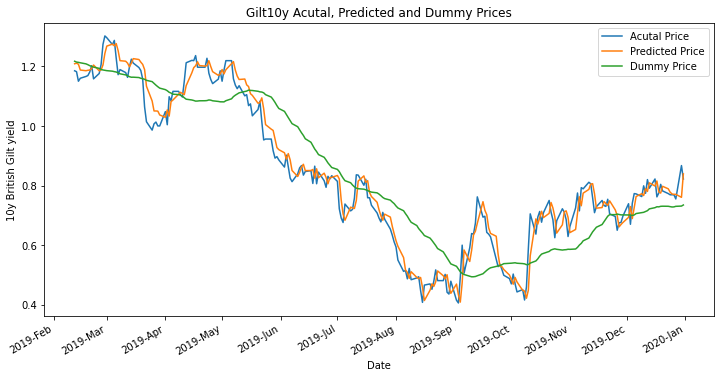

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

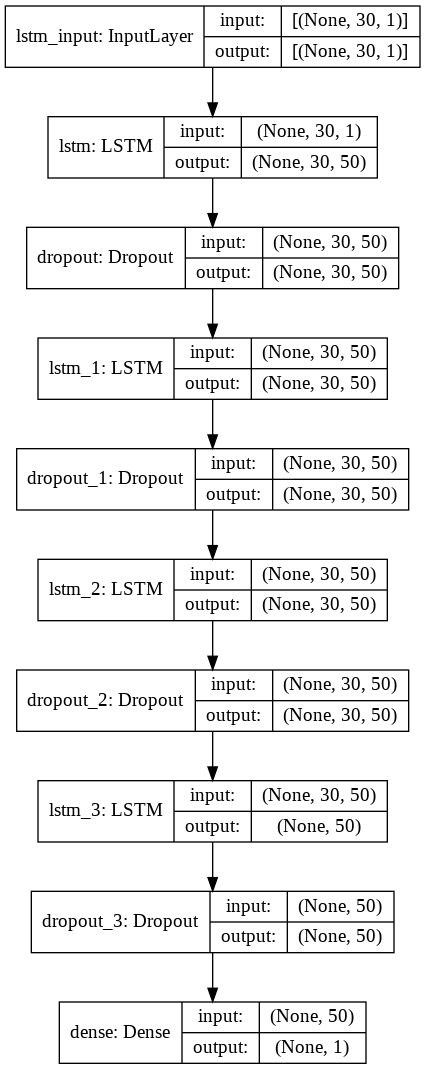

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.002437617620207195
RMSE:  0.049372235317101
MAE:  0.03805164438047454


In [23]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Gilt10y/assets
